# Emergency Patient Transportation

In [1]:
# Install required packages
#!pip install matplotlib rustworkx numpy scipy
#!pip install qiskit qiskit-ibm-runtime
#!pip install pylatexenc
#!pip install qiskit-aer

In [2]:
# Step 0 — imports
import matplotlib
import matplotlib.pyplot as plt
import math
import itertools
import rustworkx as rx
import networkx as nx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

## Classical Routing Model

In [3]:

# Step 1: Data & corrected haversine
hospital = {"name": "Central Hospital", "lat": 29.99512653425452, "lon": 31.68462840171934}

patients = [
    {"id": "DT",   "lat": 30.000417586266437, "lon": 31.73960813272627},
    {"id": "GR",   "lat": 30.011344405285193, "lon": 31.747827362371993},
    {"id": "R2",   "lat": 30.030388325206854, "lon": 31.669231198639675},
    {"id": "R3_2", "lat": 30.030940768851426, "lon": 31.688371339937028},
    {"id": "IT",   "lat": 30.01285635906825,  "lon": 31.693811715848444},
]

def haversine(coord1, coord2):
    """Return haversine distance (km) between coord1=(lat,lon) and coord2=(lat,lon)."""
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1 = math.radians(lat1); phi2 = math.radians(lat2)
    dphi = phi2 - phi1
    dlambda = math.radians(lon2) - math.radians(lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda/2)**2
    R = 6371.0
    return 2.0 * R * math.asin(math.sqrt(a))

In [4]:
# Step 2: distance tables
patient_ids = [p["id"] for p in patients]
coords = {p["id"]: (p["lat"], p["lon"]) for p in patients}
coords["H"] = (hospital["lat"], hospital["lon"])  # 'H' for hospital

# hospital -> patient distances
d_h = {pid: haversine(coords["H"], coords[pid]) for pid in patient_ids}

# patient -> patient distances
d = {}
for a in patient_ids:
    for b in patient_ids:
        d[(a, b)] = haversine(coords[a], coords[b])

# quick check
print("H -> DT (km):", d_h["DT"])
print("DT -> GR (km):", d[("DT","GR")])

H -> DT (km): 5.327124952664338
DT -> GR (km): 1.4500439631084925


In [5]:
# Step 3: trip cost & chunk generator
def trip_cost(seq):
    """Compute cost of trip visiting patients in seq (list/tuple of ids), starting+ending at hospital."""
    if not seq:
        return 0.0
    cost = d_h[seq[0]]                      # H -> first
    for i in range(len(seq) - 1):
        cost += d[(seq[i], seq[i+1])]
    cost += d_h[seq[-1]]                    # last -> H (symmetric)
    return cost

def all_chunkings(seq, max_chunk=3):
    """Yield ordered chunkings of seq where each chunk size in 1..max_chunk."""
    if not seq:
        yield []
        return
    for size in range(1, max_chunk + 1):
        if size > len(seq):
            break
        head = seq[:size]
        for rest in all_chunkings(seq[size:], max_chunk):
            yield [tuple(head)] + rest

In [23]:
# Step 4: brute-force search
best = (float("inf"), None)

for perm in itertools.permutations(patient_ids):
    for chunks in all_chunkings(list(perm), max_chunk=3):
        # ensure no chunk is larger than 3 (all_chunkings already makes that)
        total = sum(trip_cost(chunk) for chunk in chunks)
        if total < best[0]:
            best = (total, (perm, chunks))

best_total, (best_perm, best_chunks) = best
print(f"Best total distance (km): {best_total:.6f}")
print("Optimal (order-preserving) grouping of that permutation:")
for i, chunk in enumerate(best_chunks, 1):
    names = list(chunk)
    print(f" Trip {i-1}: {names}  cost = {trip_cost(chunk):.6f} km")

Best total distance (km): 23.398597
Optimal (order-preserving) grouping of that permutation:
 Trip 0: ['DT', 'GR']  cost = 13.124447 km
 Trip 1: ['R2', 'R3_2', 'IT']  cost = 10.274150 km


## Quantum model
$x_{i,t}$: patient i assigned to trip t. For N=5 and capacity K=3 we need T = ceil(5/3) = 2 trips → 10 binary variables. We encode:

Objective (approximate route cost): linear: $2*d_h[i] * x_{i,t}$ and quadratic: $d_{ij} * x_{i,t} x_{j,t}$ (if both in same trip).

This is an approximation: it does not encode travel ordering inside a trip exactly (slot-based encoding required for exact order).

Constraints as quadratic penalties:

Assignment: $A*(1 - \sum_t x_{i,t})^2$ for each patient i (exactly once).

Capacity: $B*(\sum_i x_{i,t} - 3)^2$ for each trip t.

In [7]:
# Step 5: build Binary Quadratic Model (h and J) for assignment encoding and map to QuadraticProgram for QAOA
num_patients = len(patient_ids)   # 5
max_trips = math.ceil(num_patients / 3)  # 2
vars_list = [(i, t) for i in range(num_patients) for t in range(max_trips)]
Nvars = len(vars_list)
idx_of = {vars_list[k]: k for k in range(Nvars)}

# linear (h) and quadratic (J) in x (binary)
h = {k: 0.0 for k in range(Nvars)}
J = {}  # (i,j) with i<j -> val

def add_J(a, b, val):
    if a == b:
        h[a] += val
    else:
        i, j = (a,b) if a < b else (b,a)
        J[(i,j)] = J.get((i,j), 0.0) + val

# Objective terms
# linear: 2 * dist_h[i] * x_{i,t}
for i, pid in enumerate(patient_ids):
    for t in range(max_trips):
        idx = idx_of[(i,t)]
        h[idx] += 2.0 * d_h[pid]

# pairwise: if i and j in same trip add dist_ij
for (i_idx, i_pid), (j_idx, j_pid) in itertools.combinations(enumerate(patient_ids), 2):
    d_ij = d[(i_pid, j_pid)]
    for t in range(max_trips):
        add_J(idx_of[(i_idx,t)], idx_of[(j_idx,t)], d_ij)

# Assignment penalty: each patient exactly once
A = 1000.0
for i_idx in range(num_patients):
    vars_i = [idx_of[(i_idx,t)] for t in range(max_trips)]
    for v in vars_i:
        h[v] += -A
    for a,b in itertools.combinations(vars_i, 2):
        add_J(a,b, 2.0*A)

# Capacity penalty per trip: target sum = cap (3)
B = 800.0
cap = 3
for t in range(max_trips):
    vars_t = [idx_of[(i,t)] for i in range(num_patients)]
    linear_contrib = (1.0 - 2.0*cap) * B  # (1 - 2*cap) * B
    for v in vars_t:
        h[v] += linear_contrib
    for a,b in itertools.combinations(vars_t, 2):
        add_J(a,b, 2.0 * B)

# quick check
print("Nvars:", Nvars, "vars_list[:5]:", vars_list[:5])
print("sample h (first 8):", [h[i] for i in range(min(8,Nvars))])
print("sample J (first 8):", list(J.items())[:8])


Nvars: 10 vars_list[:5]: [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0)]
sample h (first 8): [-4989.3457500946715, -4989.3457500946715, -4987.305443755134, -4987.305443755134, -4991.616304947694, -4991.616304947694, -4992.002730298039, -4992.002730298039]
sample J (first 8): [((0, 2), 1601.4500439631086), ((1, 3), 1601.4500439631086), ((0, 4), 1607.5512541413107), ((1, 5), 1607.5512541413107), ((0, 6), 1605.987977405757), ((1, 7), 1605.987977405757), ((0, 8), 1604.6216127997661), ((1, 9), 1604.6216127997661)]


We use the algebraic substitution:  $x_i = \frac{1 - Z_i}{2}.$

For a Binary Quadratic Model (BQM):
$
E(x) = \sum_i h_i x_i + \sum_{i<j} J_{ij} x_i x_j,
$

the mapping to Pauli terms (ignoring the global constant) gives:

Linear $Z_i$ coefficient:
$
\ell_i = -\tfrac{1}{2} h_i - \tfrac{1}{4} \sum_{j \neq i} J_{ij}
$

Quadratic $Z_i Z_j$ coefficient:
$
q_{ij} = \tfrac{1}{4} J_{ij}
$

Constant term (energy offset):
$
c = \tfrac{1}{2} \sum_i h_i + \tfrac{1}{4} \sum_{i<j} J_{ij}
$

In [8]:
# Step 6: map to hamiltonian

# assume h (dict idx->float), J (dict (i,j)->float i<j), Nvars defined from previous steps
# Compute constant term, linear Z coeffs and ZZ coeffs
sum_h = sum(h.values())
sum_J = sum(J.values())
const_term = 0.5 * sum_h + 0.25 * sum_J

# linear Z coefficients
Nvars = len(h)
linear_Z = np.zeros(Nvars)
for i in range(Nvars):
    row_sum = 0.0
    for j in range(Nvars):
        if i == j:
            continue
        a,b = (i,j) if i<j else (j,i)
        row_sum += J.get((a,b), 0.0)
    linear_Z[i] = -0.5 * h[i] - 0.25 * row_sum

# ZZ coefficients
zz_coeffs = {(a,b): 0.25 * val for (a,b), val in J.items()}

# Build sparse pauli list
pauli_list = []
for (a,b), c in zz_coeffs.items():
    if abs(c) > 1e-12:
        pauli_list.append(("ZZ", [a,b], float(c)))
for i in range(Nvars):
    c = float(linear_Z[i])
    if abs(c) > 1e-12:
        pauli_list.append(("Z", [i], c))

# Create SparsePauliOp
cost_hamiltonian = SparsePauliOp.from_sparse_list(pauli_list, Nvars)
print("Constant energy shift:", const_term)
print("Cost Hamiltonian (SparsePauliOp):")
print(cost_hamiltonian)

Constant energy shift: -14433.056343730672
Cost Hamiltonian (SparsePauliOp):
SparsePauliOp(['IIIIIIIZIZ', 'IIIIIIZIZI', 'IIIIIZIIIZ', 'IIIIZIIIZI', 'IIIZIIIIIZ', 'IIZIIIIIZI', 'IZIIIIIIIZ', 'ZIIIIIIIZI', 'IIIIIZIZII', 'IIIIZIZIII', 'IIIZIIIZII', 'IIZIIIZIII', 'IZIIIIIZII', 'ZIIIIIZIII', 'IIIZIZIIII', 'IIZIZIIIII', 'IZIIIZIIII', 'ZIIIZIIIII', 'IZIZIIIIII', 'ZIZIIIIIII', 'IIIIIIIIZZ', 'IIIIIIZZII', 'IIIIZZIIII', 'IIZZIIIIII', 'ZZIIIIIIII', 'IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[400.36251099+0.j, 400.36251099+0.j, 401.88781354+0.j, 401.88781354+0.j,
 401.49699435+0.j, 401.49699435+0.j, 401.1554032 +0.j, 401.1554032 +0.j,
 401.9644362 +0.j, 401.9644362 +0.j, 401.53124119+0.j, 401.53124119+0.j,
 401.30091525+0.j, 401.30091525+0.j, 400.46090104+0.j, 400.46090104+0.j,
 400.76652133+0.j, 400.76652133+0.j, 400.51949749+0.j, 400.51949749+0.j,
 500.        +0.j, 500.        

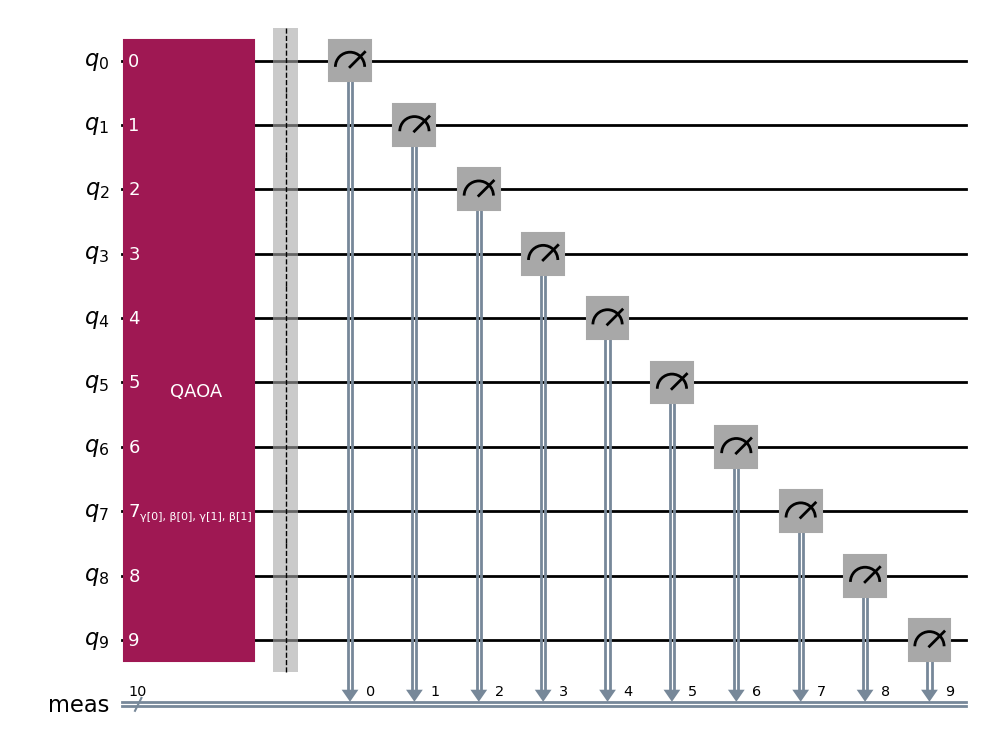

In [40]:
# Step 7: QAOA ansatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw("mpl")

AerSimulator('aer_simulator')


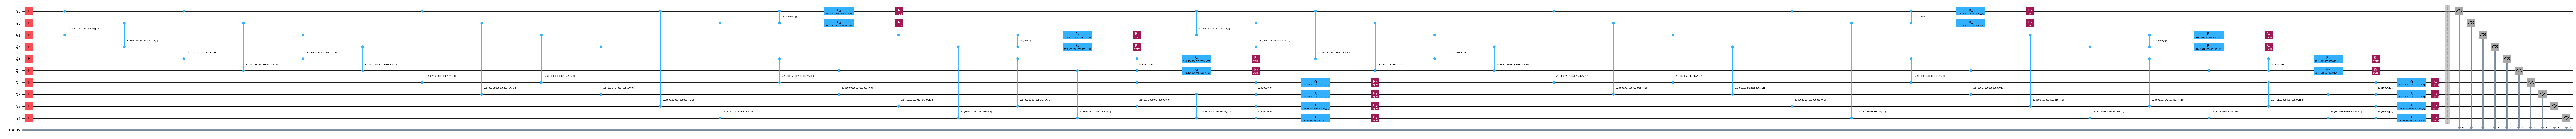

In [41]:
backend = AerSimulator()

print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [42]:
# Step 8: optimize QAOA parameters

initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

In [43]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

In [44]:
objective_func_vals = []
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -611.1393561079071
       x: [ 2.101e+00  1.540e+00  3.076e+00  2.780e+00]
    nfev: 24
   maxcv: 0.0


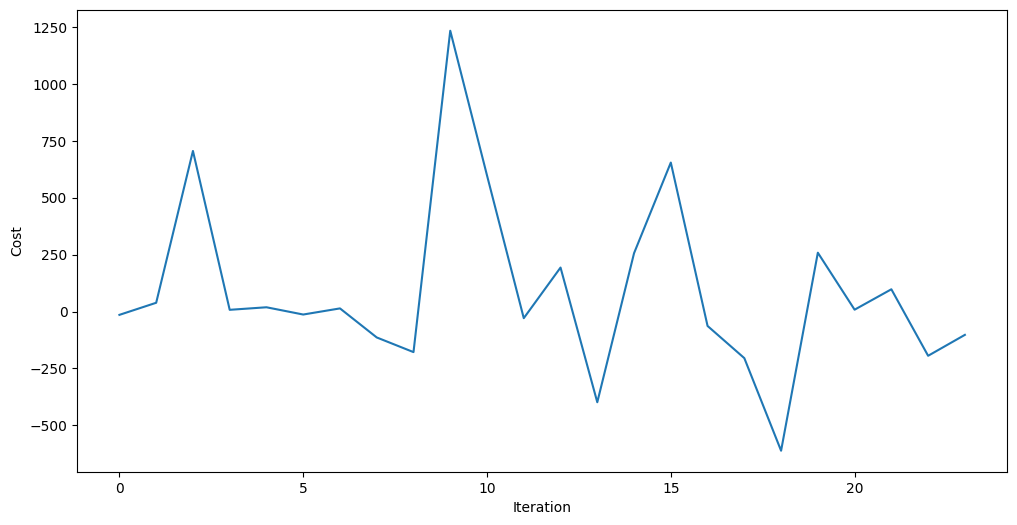

In [45]:
# step 9: Post-process and return result
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

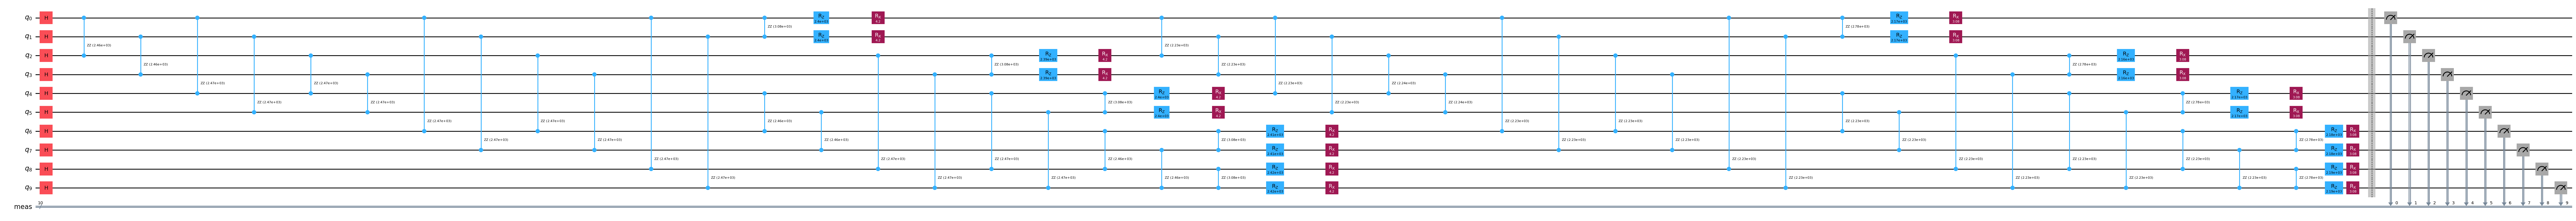

In [46]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [47]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{576: 0.0016, 60: 0.001, 808: 0.0014, 948: 0.0034, 897: 0.0005, 865: 0.0042, 569: 0.0076, 187: 0.0059, 400: 0.0039, 111: 0.0001, 523: 0.0008, 956: 0.0026, 494: 0.001, 727: 0.0038, 47: 0.002, 346: 0.0054, 487: 0.0014, 889: 0.0061, 38: 0.0017, 98: 0.0067, 348: 0.0002, 689: 0.003, 950: 0.007, 328: 0.0001, 354: 0.0054, 193: 0.0005, 985: 0.0019, 610: 0.0012, 379: 0.0056, 39: 0.0068, 240: 0.0002, 59: 0.0116, 843: 0.0016, 693: 0.0074, 51: 0.0036, 95: 0.0024, 128: 0.0015, 363: 0.0063, 468: 0.0013, 358: 0.0042, 749: 0.0003, 1017: 0.002, 506: 0.0036, 795: 0.0052, 524: 0.0003, 353: 0.0026, 90: 0.0041, 559: 0.0002, 438: 0.0019, 35: 0.0021, 148: 0.0019, 266: 0.0013, 501: 0.0004, 99: 0.0003, 722: 0.0034, 593: 0.0007, 934: 0.0025, 370: 0.0025, 498: 0.0004, 832: 0.0004, 226: 0.0026, 810: 0.0002, 121: 0.0017, 978: 0.0028, 757: 0.0037, 557: 0.0034, 274: 0.0009, 299: 0.0003, 55: 0.0122, 1003: 0.0011, 599: 0.0009, 738: 0.0097, 712: 0.0004, 909: 0.0003, 106: 0.0052, 544: 0.0014, 616: 0.0054, 828: 0.008, 82

Filtered out the invalid bitstrings before plotting or decoding:

No patient is duplicated.

No patient is forgotten.

No trip exceeds 3 patients.:

In [48]:
# auxiliary function
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

# validity check
def is_valid(bitstring, vars_list, num_patients, max_per_trip=3):
    assigned = {}
    trip_counts = {0: 0, 1: 0}  # assuming 2 trips
    for idx, (patient_idx, trip_idx) in enumerate(vars_list):
        if bitstring[idx] == 1:
            if patient_idx in assigned:  # same patient assigned twice
                return False
            assigned[patient_idx] = trip_idx
            trip_counts[trip_idx] += 1
            if trip_counts[trip_idx] > max_per_trip:  # trip capacity exceeded
                return False

    # every patient must be assigned exactly once
    if len(assigned) != num_patients:
        return False

    return True

# filter valid bitstrings
valid_distribution_int = {}
for key, prob in final_distribution_int.items():
    candidate = to_bitstring(key, len(vars_list))
    candidate.reverse()
    if is_valid(candidate, vars_list, num_patients=len(patient_ids)):
        valid_distribution_int[key] = prob

# re-normalize
norm_factor = sum(valid_distribution_int.values())
valid_distribution_int = {k: v / norm_factor for k, v in valid_distribution_int.items()}

# select most likely valid bitstring
most_likely = max(valid_distribution_int, key=valid_distribution_int.get)
most_likely_bitstring = to_bitstring(most_likely, len(vars_list))
most_likely_bitstring.reverse()

print("Result bitstring (valid):", most_likely_bitstring)

Result bitstring (valid): [1, 0, 1, 0, 0, 1, 0, 1, 0, 1]


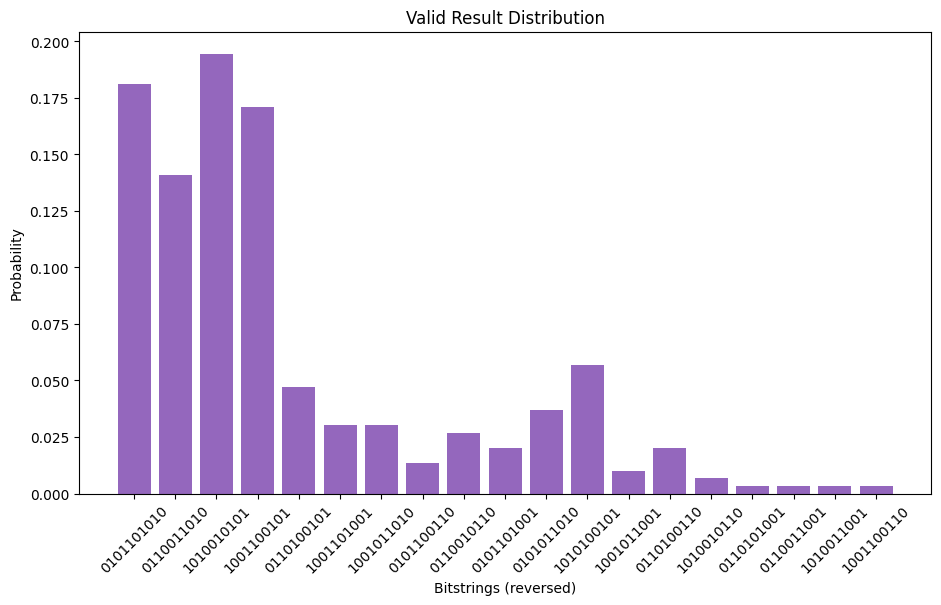

In [49]:
# plot only valid
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Valid Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(
    [np.binary_repr(k, len(vars_list))[::-1] for k in valid_distribution_int.keys()],
    list(valid_distribution_int.values()),
    color="tab:purple",
)
plt.show()

In [50]:
# decode assignments
assignments = {0: [], 1: []}
for k, bit in enumerate(most_likely_bitstring):
    if bit == 1:
        patient_idx, trip_idx = vars_list[k]
        assignments[trip_idx].append(patient_ids[patient_idx])

assignments

{0: ['DT', 'GR'], 1: ['R2', 'R3_2', 'IT']}

In [51]:
# --- Decode QAOA result ---
assignments = {0: [], 1: []}
for k, bit in enumerate(most_likely_bitstring):
    if bit == 1:
        patient_idx, trip_idx = vars_list[k]
        assignments[trip_idx].append(patient_ids[patient_idx])

# --- Compute trip costs using same classical trip_cost function ---
quantum_total = 0.0
for trip_idx, patient_list in assignments.items():
    if patient_list:  # skip empty
        cost = trip_cost(patient_list)
        print(f" Trip {trip_idx}: {patient_list}, cost = {cost:.6f} km")
        quantum_total += cost

print(f"Quantum total distance (km): {quantum_total:.6f}")

# --- Compare with brute force ---
print("\nClassical best total distance (km):", best_total)
print("Quantum found total distance (km):", quantum_total)

 Trip 0: ['DT', 'GR'], cost = 13.124447 km
 Trip 1: ['R2', 'R3_2', 'IT'], cost = 10.274150 km
Quantum total distance (km): 23.398597

Classical best total distance (km): 23.398596808280352
Quantum found total distance (km): 23.398596808280352
